# Should we do everything in Fourier space?

In [42]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution

def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  dataset_cls=datasets.NonlinearGPDataset,
  batch_size=10000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu',
  use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  evaluation_interval=20,
)

Already simulated


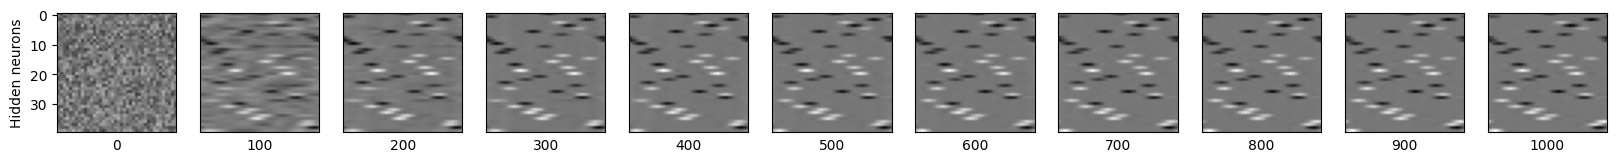

In [44]:
# load ReLU model for high gain data
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=5., num_epochs=5000, gain=3,
    batch_size=10000, evaluation_interval=500,
))

weights_high, metrics_high = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights_high, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

We see Mexican hats/Gabors!

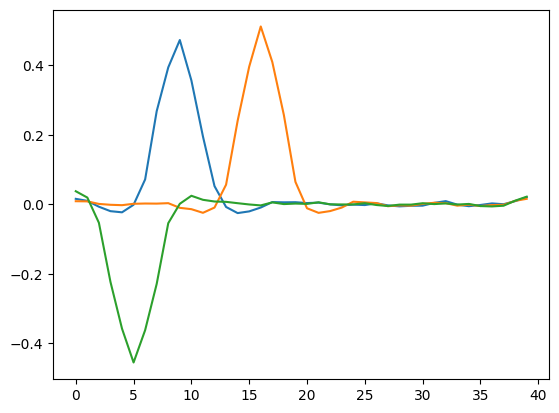

In [45]:
# plot the first three RFs
_ = plt.plot(weights_high[-1][:3].T)

Already simulated


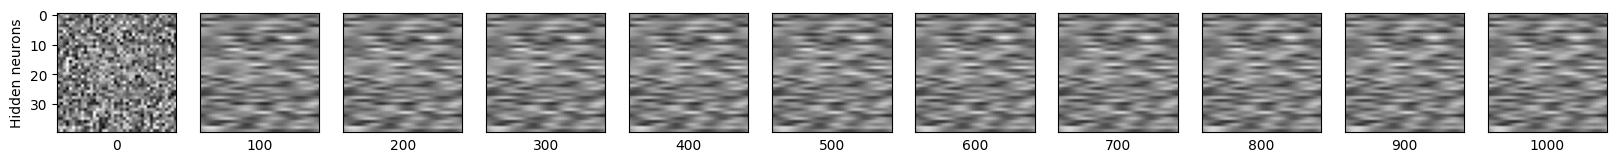

In [49]:
# load ReLU model for low gain data
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=5., num_epochs=5000, gain=0.01,
    batch_size=10000, evaluation_interval=500,
))

weights_low, metrics_low = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights_low, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

We see long-range oscillations!

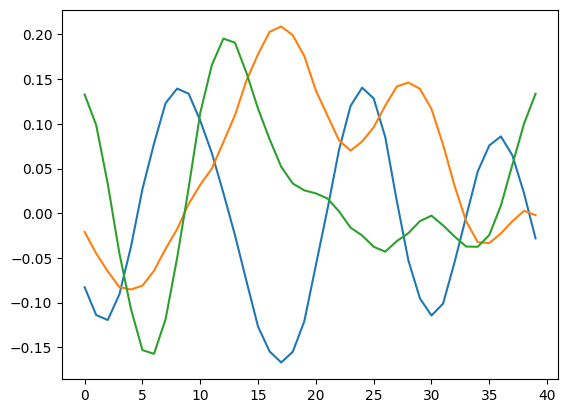

In [50]:
# plot the first three RFs
_ = plt.plot(weights_low[-1][:3].T)

## In Fourier space

In [59]:
config['gain'] = 3.
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config)
x, y = dataset[:10000]
n = config['num_dimensions']

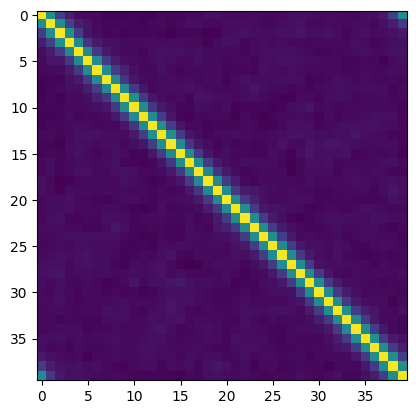

In [64]:
cov_ = x.T @ x / len(x)
plt.imshow(cov_)

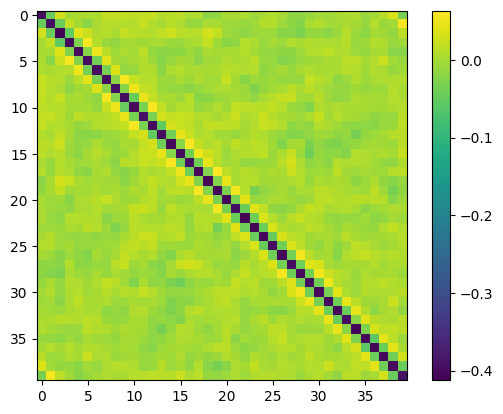

In [69]:
C = build_gaussian_covariance(n, config['xi1'])
Z = lambda g: jnp.sqrt( (2/jnp.pi) * jnp.arcsin( (g**2) / (1 + (g**2)) ) )
pred_ = (2 / jnp.pi / Z(config['gain'])) * jnp.arcsin( (config['gain']**2) / (1 + (config['gain']**2)) * C)
im = plt.imshow(pred_ - cov_)
cbar = plt.colorbar(im)

In [70]:
pred_ - cov_

Array([[-0.39910167, -0.04772457,  0.03165855, ...,  0.0131138 ,
         0.03684327, -0.03468153],
       [-0.04772457, -0.39577144, -0.04452243, ..., -0.00713804,
        -0.00156044,  0.05711856],
       [ 0.03165855, -0.04452243, -0.4081548 , ..., -0.00349861,
        -0.01202164,  0.01617694],
       ...,
       [ 0.01311379, -0.00713804, -0.00349861, ..., -0.40317947,
        -0.04020599,  0.03046055],
       [ 0.03684327, -0.00156044, -0.01202164, ..., -0.04020599,
        -0.40104717, -0.04532471],
       [-0.03468165,  0.05711856,  0.01617694, ...,  0.03046055,
        -0.04532471, -0.3892569 ]], dtype=float32)

#### Defining Discrete Transform

In [36]:
# discrete Fourier transform
n = config_['num_dimensions']
DFT = np.zeros((n, n), dtype=complex)
w = np.exp(-2 * np.pi * 1j / n)
for i in range(DFT.shape[0]):
    DFT[:, i] = w ** (i * np.arange(n))
DFT /= np.sqrt(n)

# making it real
DCT = DFT.real
DST = DFT.imag

DRT_ = np.sqrt(2) * np.concatenate((DCT[:, :(n//2+1)], DST[:, 1:(n//2)]), axis=1)
DRT_[:,0] /= np.sqrt(2)
DRT_[:,n//2] /= np.sqrt(2)
DRT = np.zeros((n, n))
DRT[:,0] = DRT_[:,0]
DRT[:,1::2] = DRT_[:,1:n//2+1]
DRT[:,2::2] = DRT_[:,n//2+1:]

# check that it forms an orthonormal basis for R^n
print( np.linalg.norm(DRT.T @ DRT - np.eye(n)) )

1.397525836506499e-13


xi1 = 2
1.1864271561990067e-13


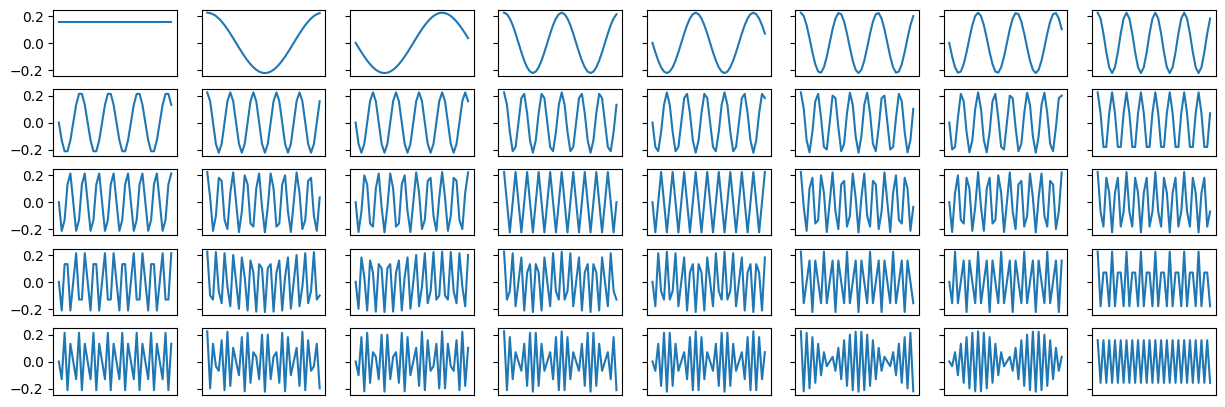

In [37]:
fig, axs = plt.subplots(5, 8, figsize=(15, 5), sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(DRT[:, i])
    ax.set_xticks([])
    
# check that it diagonalizes the covariance matrix
xi1 = config['xi1']
print('xi1 =', xi1)
Sigma = build_gaussian_covariance(n, xi1)
Lambda = np.diag(DRT.T @ Sigma @ DRT)
# it does!
print( np.linalg.norm(Sigma - DRT @ np.diag(Lambda) @ DRT.T) )

#### Receptive fields in Fourier space

In [51]:
fourier_high = np.inner(weights_high, DRT.T)#.reshape(-1, 1, n)
fourier_low = np.inner(weights_low, DRT.T)#.reshape(-1, 1, n)

Text(0.5, 1.0, 'Low gain, Fourier')

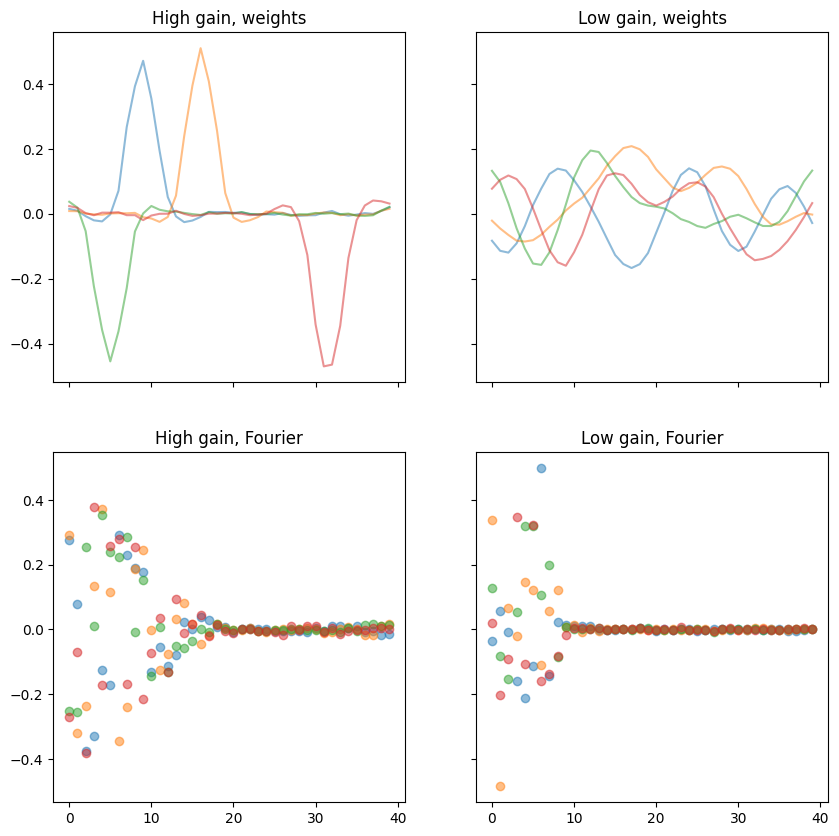

In [52]:
n_ = 4
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey="row")
axs[0,0].plot( weights_high[-1,:n_].T, alpha=0.5 )
axs[0,0].set_title('High gain, weights')
axs[0,1].plot( weights_low[-1,:n_].T, alpha=0.5 )
axs[0,1].set_title('Low gain, weights')
axs[1,0].plot( fourier_high[-1,:n_].T, 'o', alpha=0.5 )
axs[1,0].set_title('High gain, Fourier')
axs[1,1].plot( fourier_low[-1,:n_].T, 'o', alpha=0.5 )
axs[1,1].set_title('Low gain, Fourier')

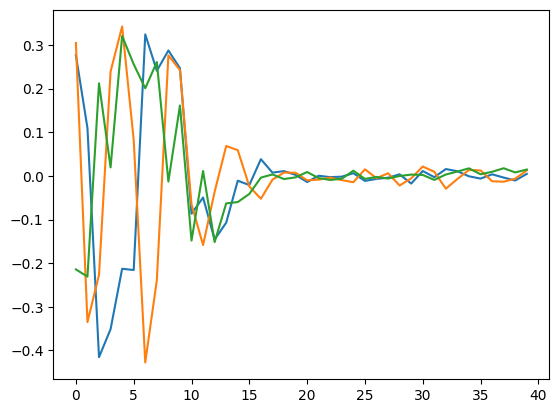

In [17]:
_ = plt.plot( fourier_high[-1,:3].T )

## From write-up notebook

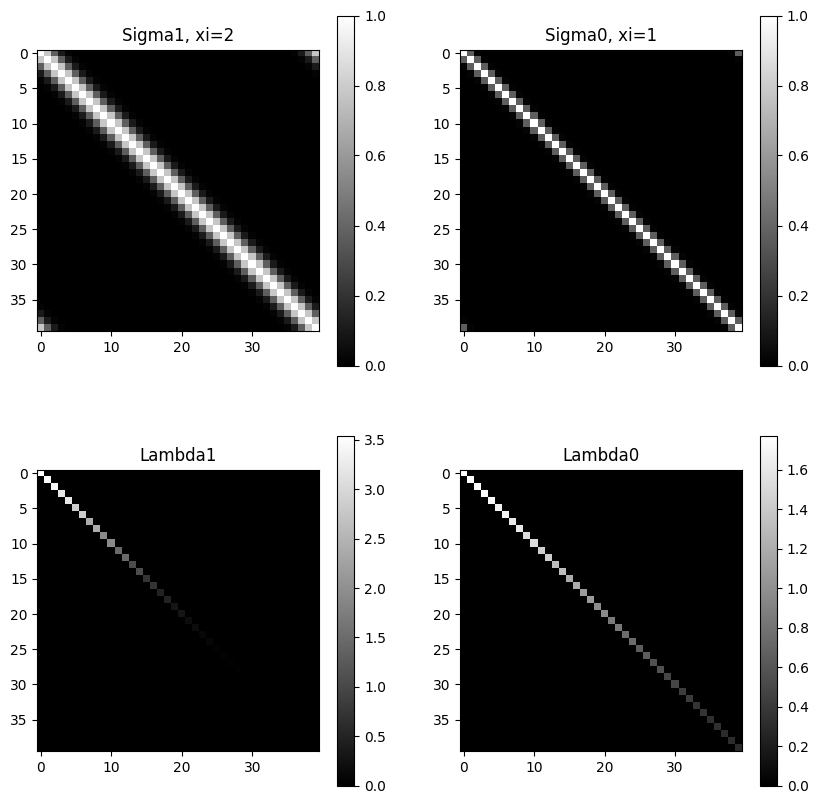

In [191]:
# visualize the covariance matrices driving the dynamics
Sigma1 = build_gaussian_covariance(n, config['xi1'])
Sigma0 = build_gaussian_covariance(n, config['xi2'])
Lambda1, Lambda0 = DRT.T @ Sigma1 @ DRT, DRT.T @ Sigma0 @ DRT
Lambda1, Lambda0 = np.diag(Lambda1), np.diag(Lambda0)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
im = axs[0,0].imshow(Sigma1, cmap='gray')
axs[0,0].set_title('Sigma1, xi=' + str(config['xi1']))
_ = plt.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(Sigma0, cmap='gray')
axs[0,1].set_title('Sigma0, xi=' + str(config['xi2']))
_ = plt.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(np.diag(Lambda1), cmap='gray')
axs[1,0].set_title('Lambda1')
_ = plt.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(np.diag(Lambda0), cmap='gray')
axs[1,1].set_title('Lambda0')
_ = plt.colorbar(im, ax=axs[1,1])

We see that long-range oscillations dominate more over smaller ones for $\xi_1$ than $\xi_2$.
Moreover, the weights for long-range oscillations are greater for $\xi_1$ than $\xi_2$, while the reverse is true for short-range oscillations.
This may help us explain why setting $Y=1$ to correspond to $\xi_1$ yields long-range oscillations, while we get short-range oscillations when $Y=1$ corresponds to $\xi_2$.

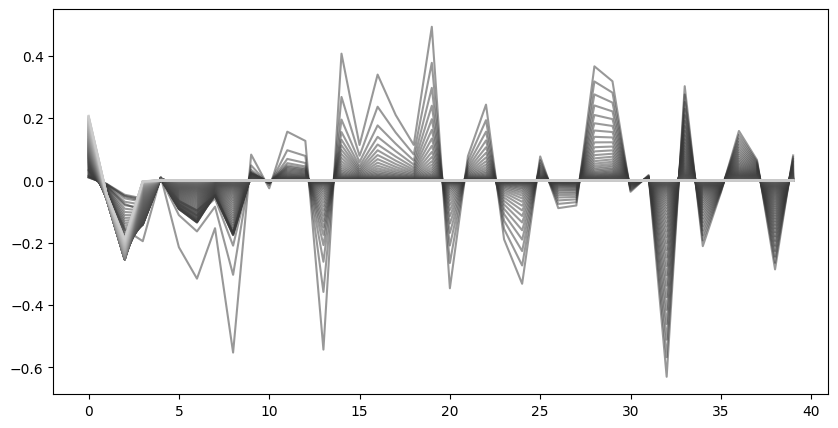

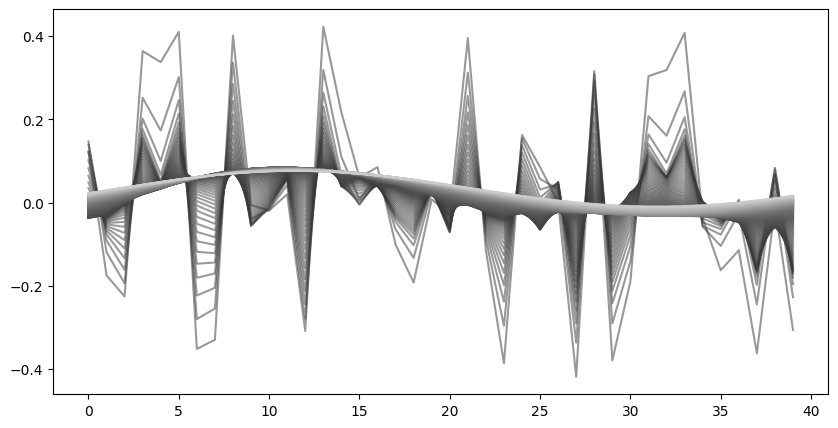

In [201]:
u1 = np.zeros((config['num_epochs'], n))
diag = np.zeros((config['num_epochs'], n))

u1[0] = DRT.T @ weights[0][0]
lr = config['learning_rate']
for t in range(1, config['num_epochs']):
    u1_ = u1[t-1]
    # norm_ = np.asarray(u1_.T @ Lambda1 @ u1_)[0][0]
    norm_ = ( u1_ * Lambda1 * u1_ ).sum()
    diag[t] = Lambda0 + ( 1 - np.sqrt(2/np.pi) * (1 / np.sqrt(norm_)) ) * Lambda1
    step = -0.25 * diag[t] * u1_
    u1[t] = 10 * lr * step + u1_
# in Fourier space
fig, axs = plot_rf_evolution(u1[::10].reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
# in real space
u1_ = np.asarray(np.inner(u1, DRT))
fig, axs = plot_rf_evolution(u1_[::10].reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
fig.savefig('../thoughts/towards_gdln/figs/math/long_range_theory.png', dpi=300)

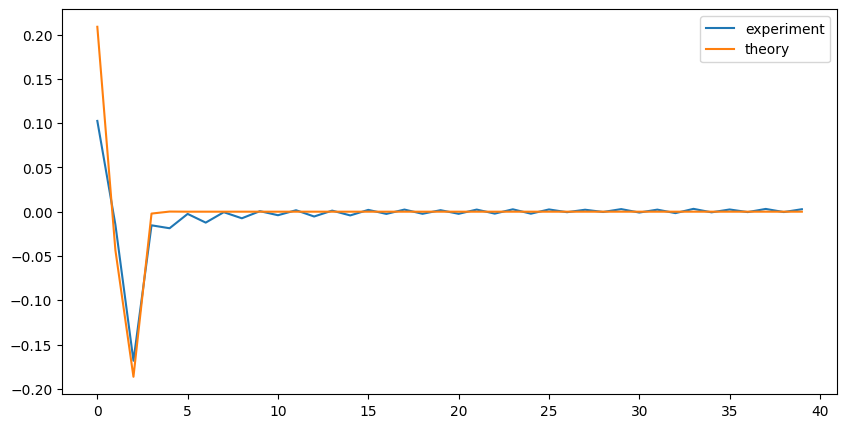

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ = ax.plot(weights_[-1][0], label='experiment')
_ = ax.plot(u1[-1], label='theory')
_ = ax.legend()
fig.savefig('../thoughts/towards_gdln/figs/math/theory_vs_experiment.png', dpi=300)

Looks pretty sexy to me!

Can we also explain why we get short-range oscillations when we flip the class label?
This amounts to swapping $\Lambda_1$ and $\Lambda_0$ in the ODE equation.

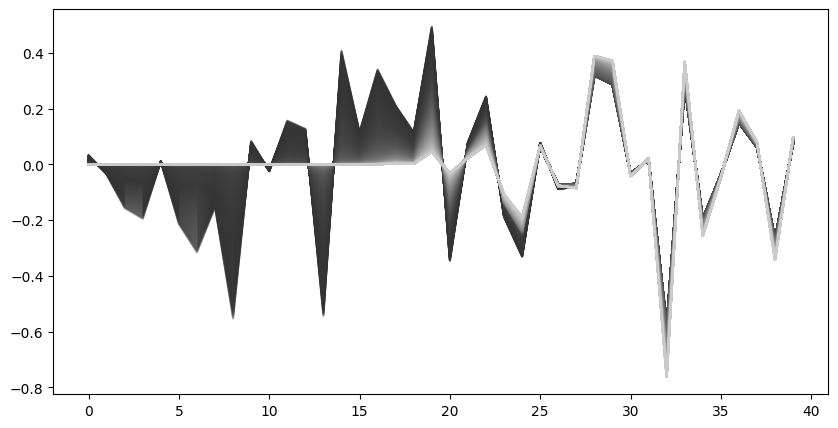

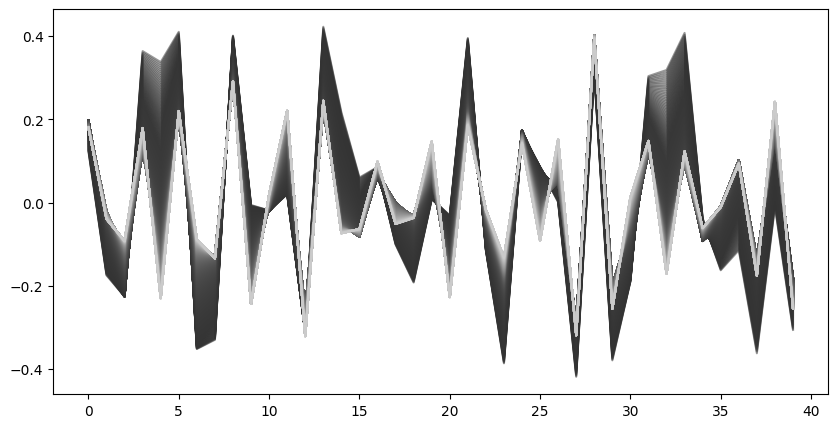

In [176]:
u1 = np.zeros((config['num_epochs'], n))
diag = np.zeros((config['num_epochs'], n))

u1[0] = DRT.T @ weights[0][0]
lr = config['learning_rate']
for t in range(1, config['num_epochs']):
    u1_ = u1[t-1]
    # norm_ = np.asarray(u1_.T @ Lambda1 @ u1_)[0][0]
    norm_ = ( u1_.conj() * Lambda0 * u1_ ).sum()
    diag[t] = Lambda1 + ( 1 - np.sqrt(2/np.pi) * (1 / np.sqrt(norm_)) ) * Lambda0
    step = -0.25 * diag[t] * u1_
    u1[t] = 2 * lr * step + u1_
# in Fourier space
fig, axs = plot_rf_evolution(u1.reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
# in real space
u1_ = np.asarray(np.inner(u1, DRT))
fig, axs = plot_rf_evolution(u1_.real.reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))

Let's goooooooo!

#### Empirically, what happens with higher gain?

Already simulated


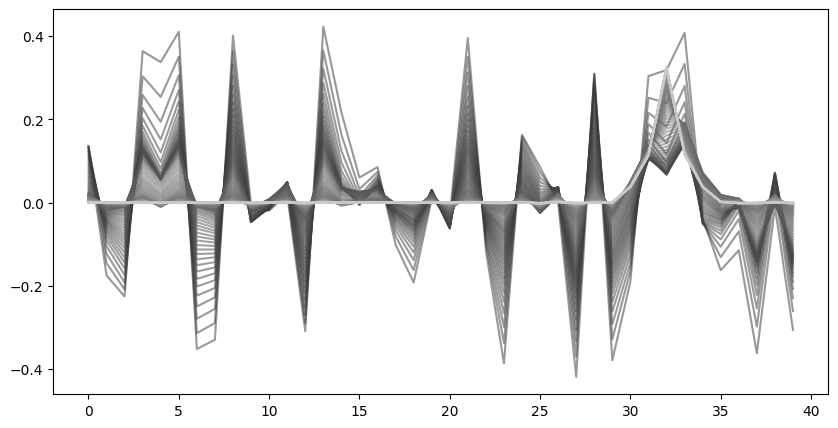

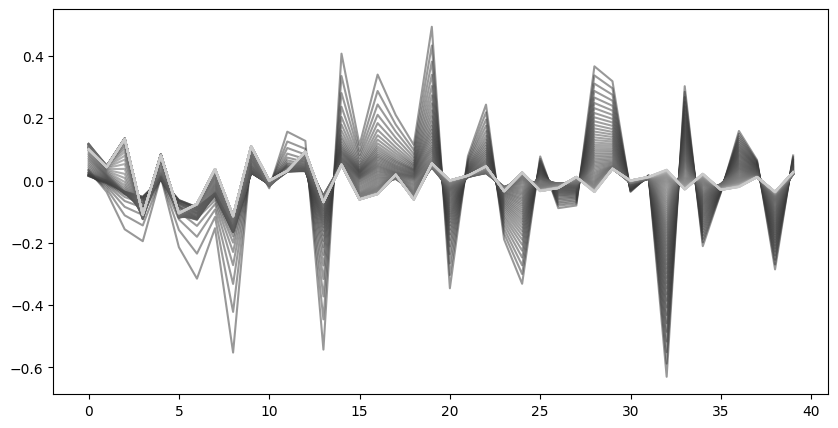

In [271]:
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.01
config['num_epochs'] = 2000
config['use_bias'] = False
config['init_scale'] = 1.0
config['gain'] = 3.

weights, metrics = simulate_or_load(**config)
# in real space
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))
# in Fourier space
weights_ = np.asarray(np.inner(weights, DRT.T)).reshape(-1, 1, n)
fig, axs = plot_rf_evolution(weights_, num_cols=1, num_rows=1, figsize=(10, 5))

### Multiple neurons

Empirically, what happens to the order parameter
$$
    \gamma = \frac{ w_i^\top \Sigma w_j }{ \sqrt{ (w_i^\top \Sigma w_i) (w_j^\top \Sigma w_j) } }
$$
in both the low and high gain settings?

Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'batch_size': 10000,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'evaluation_interval': 20,
 'gain': 3.0,
 'init_fn': <function xavier_normal_init at 0x14e9f6d40>,
 'init_scale': 1.0,
 'kwargs': {},
 'learning_rate': 0.01,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 2000,
 'num_hiddens': 1,
 'optimizer_fn': <function sgd at 0x14d7b80e0>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (-1, 1),
 'use_bias': False,
 'wandb_': False,
 'xi1': 2,
 'xi2': 1}

Length of train dataset: 20000000
Length of eval dataset: 1000
Length of train sampler: 20000000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[1,40],
    bias=None,
    in_features=40,
    out_features=1,
    use_bias=False
  ),
  act=<wrapped func

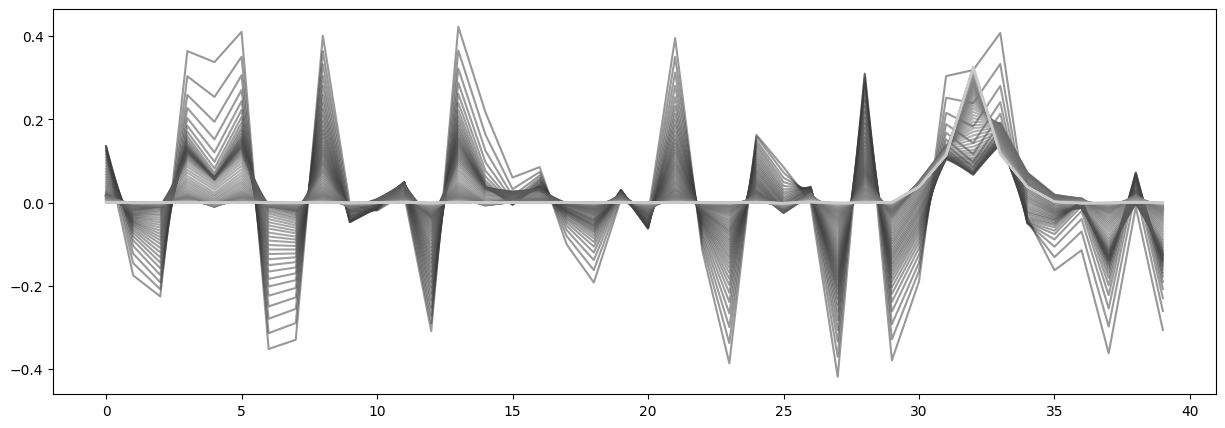

In [28]:
# what if we make w1(0) \propto 1 (+ noise)?
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.01
config['num_epochs'] = 2000
config['use_bias'] = False
# config['init_fn'] = lambda weight, key, scale: scale * (1. + models.xavier_normal_init(weight, key, 0.1))
config['init_scale'] = 1. #0.01
config['gain'] = 3.

weights, metrics = simulate_or_load(**config)
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1)

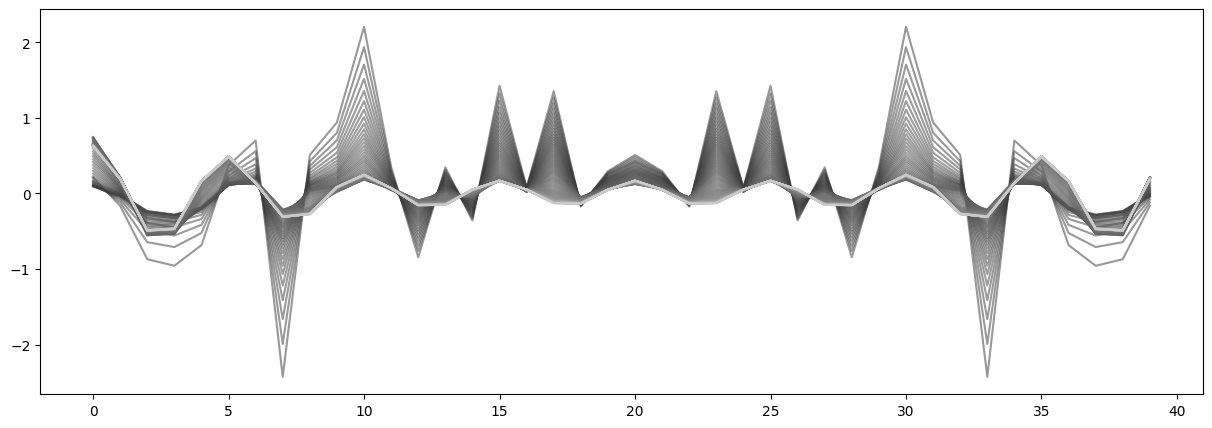

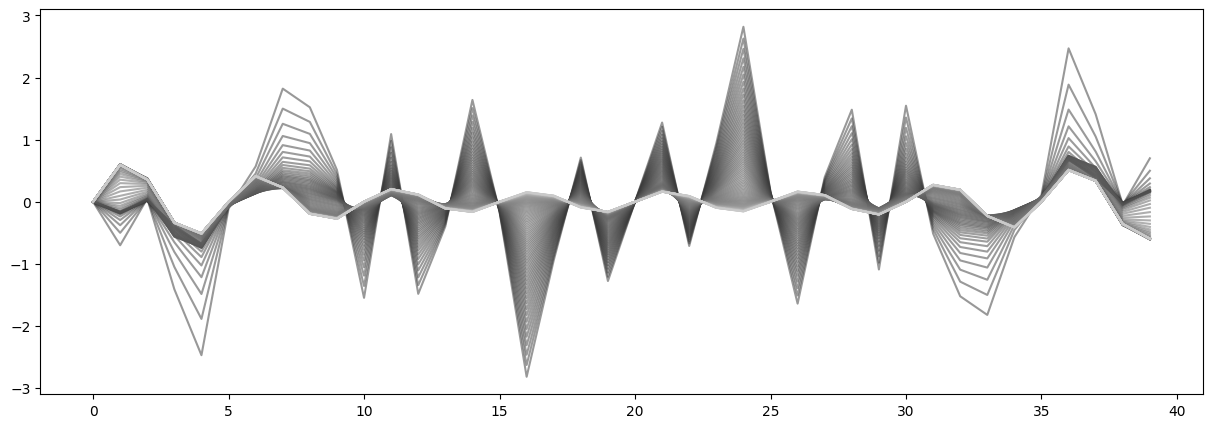

In [65]:
# discrete Fourier transform
F = np.zeros((config['num_dimensions'], config['num_dimensions']), dtype=complex)
w = np.exp(2 * np.pi * 1j / config['num_dimensions'])
for i in range(F.shape[0]):
    F[:, i] = w ** (i * np.arange(F.shape[0]))
weights_ = np.dot(weights, F.real - 1j * F.imag)
fig, axs = plot_rf_evolution(weights_.real, num_cols=1, num_rows=1)
fig, axs = plot_rf_evolution(weights_.imag, num_cols=1, num_rows=1)

### Non-Gaussian Data

As $g$ gets large, $\frac{1}{Z(g)} \text{erf}(g z_i) \to \text{sign}(z_i)$.
So, for $x \in \{ \pm 1 \}^n$,
$$
    \mathbb{P}( X = x )
    = \mathbb{P}( \text{sign}(Z) = x )
    = \mathbb{P}( \forall i: x_i Z_i > 0 ).
$$

In [410]:
L = 14 # config['num_dimensions']
N = 1000000
xi = 3. # config['xi1']
Sigma = build_gaussian_covariance(L, xi)
x_ = np.random.multivariate_normal(np.zeros(L), Sigma, size=(N,))

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_94977/1239668083.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x_ = np.random.multivariate_normal(np.zeros(L), Sigma, size=(N,))


In [413]:
# x = 2 * np.random.randint(0, 2, (N,L)) - 1
x = -np.ones(L)
np.all(np.sign(x_) == x, axis=1).mean()

0.064933

## Gated Analysis

In [6]:
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config)
x, y = dataset[:10000]
n = config['num_dimensions']

### Sign-flipping

See script.

### Predicting localization location

### Early dynamics

In [76]:
def viz_A(A):
    A = np.concatenate( np.concatenate(A, axis=2), axis=0 )
    D, P = np.linalg.eigh(A)

    # visualizing A
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    im = ax1.imshow(A, cmap='gray')
    plt.colorbar(im, ax=ax1)
    # im = ax2.imshow(np.diag(D), cmap='gray')
    # plt.colorbar(im, ax=ax2)
    ax2.plot(D)
    im = ax3.imshow(P, cmap='gray')
    plt.colorbar(im, ax=ax3)
    return fig, (ax1, ax2, ax3)

In [69]:
# small bump gate
A_small = np.stack([ [(x * (x[:,i] > 0).reshape(-1,1)).T @ (x * (x[:,j] > 0).reshape(-1,1)) / len(x) for i in range(n) ] for j in range(n) ])

# random gate
gates = jax.random.randint(jax.random.PRNGKey(0), (len(x), n), minval=0, maxval=2)
A_rand = np.stack([ [(x * gates[:,i].reshape(-1,1)).T @ (x * gates[:,j].reshape(-1,1)) / len(x) for i in range(n) ] for j in range(n) ])

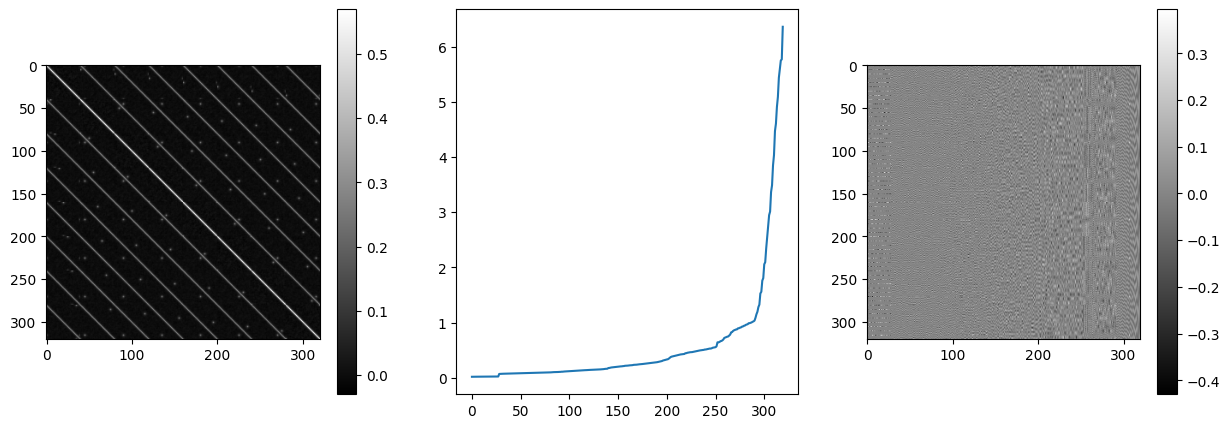

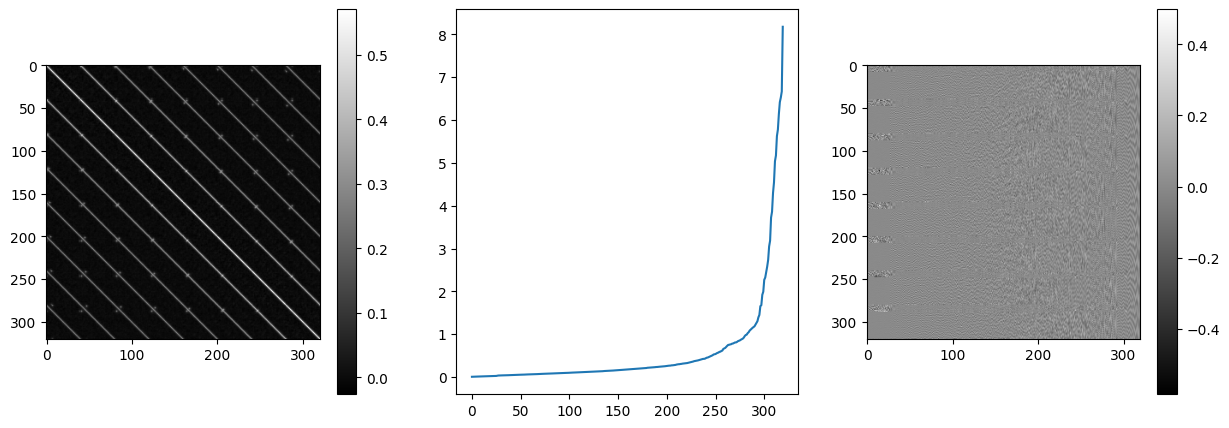

In [89]:
# small bump gate
# sparsely sampled
t = np.arange(40)[::5]
A_ = A_small[t][:,t]
fig, axs = viz_A(A_)

# sequentially sampled
t = np.arange(8)
A_ = A_small[t][:,t]
fig, axs = viz_A(A_)

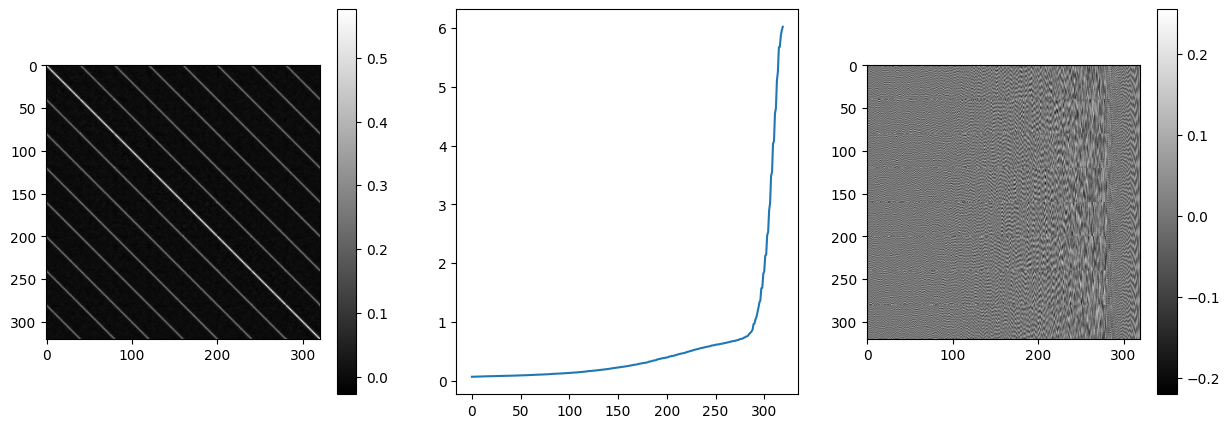

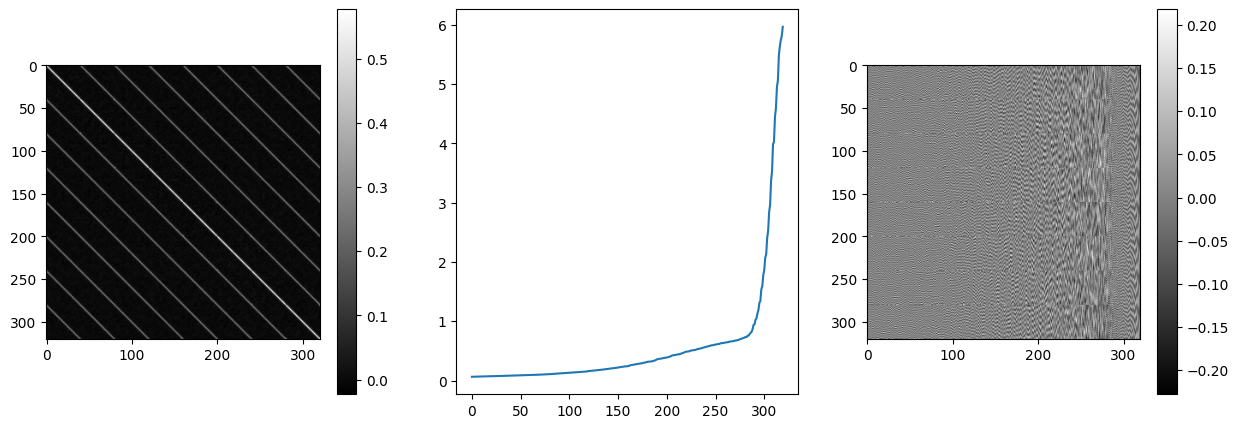

In [85]:
# random gate
# sparsely sampled
t = np.arange(40)[::5]
A_ = A_rand[t][:,t]
fig, axs = viz_A(A_)

# sequentially sampled
t = np.arange(8)
A_ = A_rand[t][:,t]
fig, axs = viz_A(A_)

In [ ]:
# all on
gates = jax.random.randint(jax.random.PRNGKey(0), (len(x), n), minval=0, maxval=2)
A_rand = np.stack([ [(x * gates[:,i].reshape(-1,1)).T @ (x * gates[:,j].reshape(-1,1)) / len(x) for i in range(n) ] for j in range(n) ])

### Meta-optimization

### Structure in Limiting Behavior

In [15]:
n = config['num_dimensions']
def sigma_yx(n, xi1, g):
    i = n//2
    r = np.exp( - (np.arange(n) - i) ** 2 / (xi1 ** 2) )
    sigma_yx = (1/np.sqrt(np.pi)) * np.arctan( r / ( 1/(2*(g**2)) + (1 - r**2) ) )
    return sigma_yx

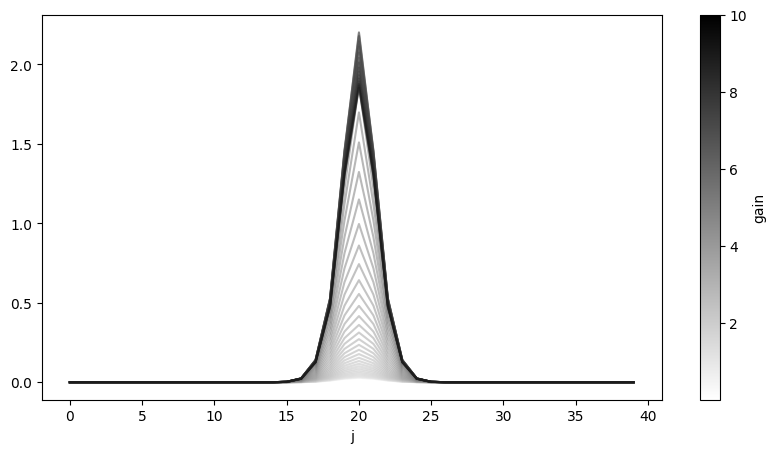

In [33]:
Z = lambda g: np.sqrt( (2/np.pi) * np.arcsin( (g**2) / ( 1 + (g**2) ) ) )
gains = np.logspace(-2, 1, 50)
sigma_yx_ = np.stack([ sigma_yx(n, config['xi1'], g) / Z(g) for g in gains ])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cmap_ = plt.get_cmap('binary')
color = cmap_(np.linspace(0.1, 0.9, len(gains)))
for t in range(len(gains)):
    p = ax.plot(sigma_yx_[t,:], color=color[t], alpha=0.5)
ax.set_xlabel('j')
# add colorbar to ax
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=plt.Normalize(vmin=gains.min(), vmax=gains.max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
# label colorbar
cbar.set_label('gain')
fig.savefig('../thoughts/towards_gdln/figs/math/sigma_yx.png', dpi=300)

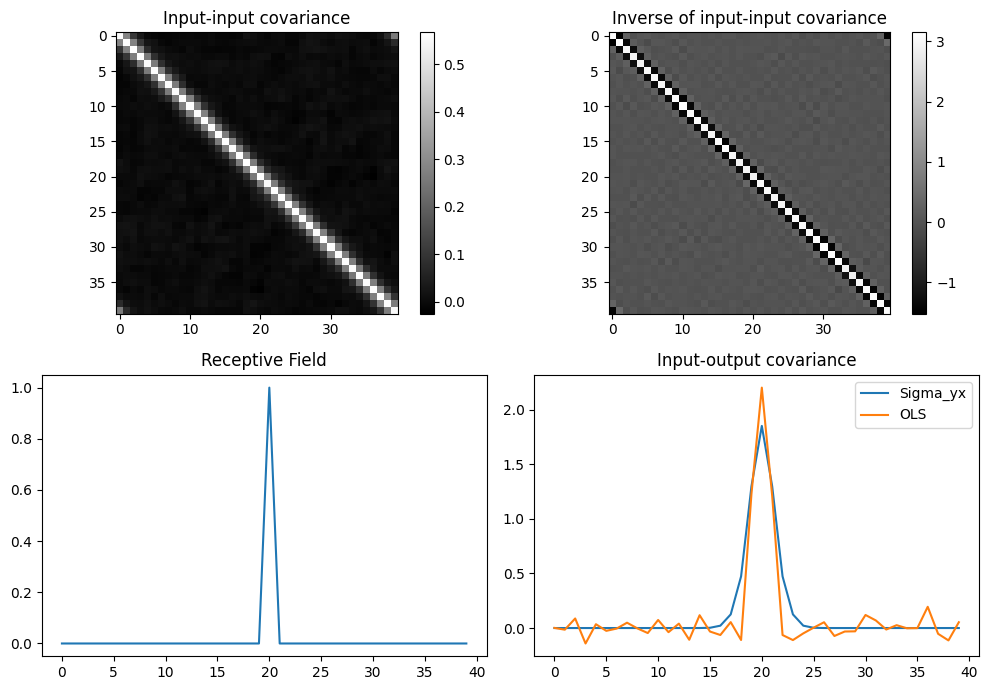

In [105]:
# small bump gate
rf = np.zeros(n); rf[20] = 1.
gate = x @ rf > 0
A = (x[gate].T @ x[gate]) / len(x)
# plot it
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
im = axs[0,0].imshow(A, cmap='gray')
_ = plt.colorbar(im)
axs[0,0].set_title("Input-input covariance")
im = axs[0,1].imshow(np.linalg.inv(A), cmap='gray')
plt.colorbar(im)
axs[0,1].set_title("Inverse of input-input covariance")
axs[1,0].plot(rf)
axs[1,0].set_title("Receptive Field")
axs[1,1].plot(sigma_yx_[-1], label="Sigma_yx")
axs[1,1].plot(np.linalg.inv(A) @ sigma_yx_[-1], label="OLS")
axs[1,1].set_title("Input-output covariance")
axs[1,1].legend()
fig.tight_layout()
fig.savefig('../thoughts/towards_gdln/figs/math/OLS_small_bump.png', dpi=300)

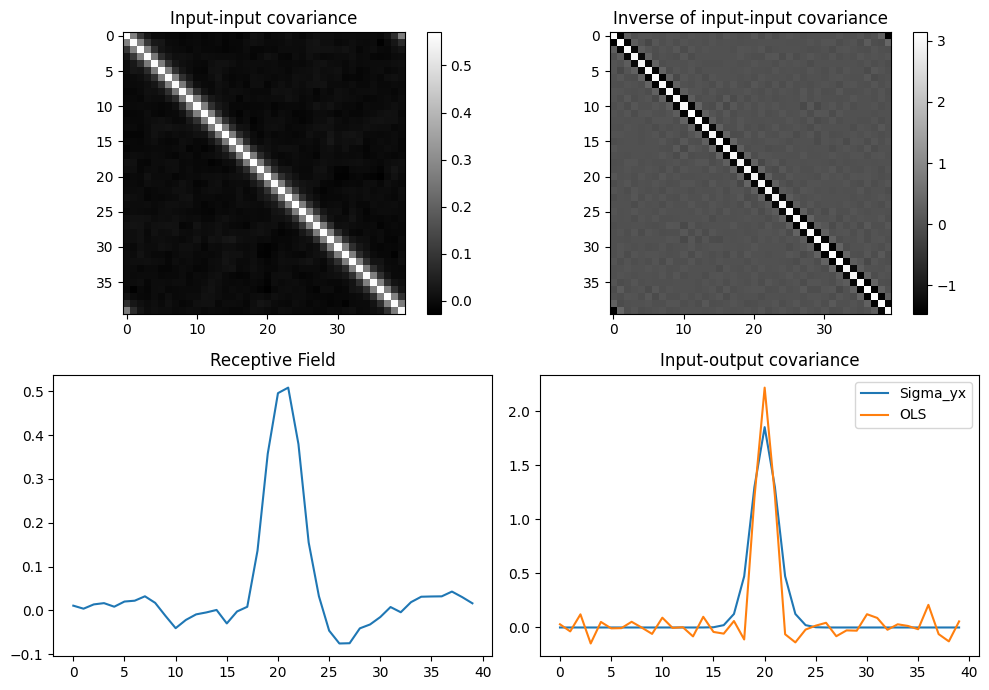

In [104]:
# Mexican hat gate
rf = weights[-1][5]
gate = x @ rf > 0
A = (x[gate].T @ x[gate]) / len(x)
# plot it
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
im = axs[0,0].imshow(A, cmap='gray')
plt.colorbar(im)
axs[0,0].set_title("Input-input covariance")
im = axs[0,1].imshow(np.linalg.inv(A), cmap='gray')
plt.colorbar(im)
axs[0,1].set_title("Inverse of input-input covariance")
axs[1,0].plot(rf)
axs[1,0].set_title("Receptive Field")
axs[1,1].plot(sigma_yx_[-1], label="Sigma_yx")
axs[1,1].plot(np.linalg.inv(A) @ sigma_yx_[-1], label="OLS")
axs[1,1].set_title("Input-output covariance")
axs[1,1].legend()
fig.tight_layout()
fig.savefig('../thoughts/towards_gdln/figs/math/OLS_mexican_hat.png', dpi=300)